# Breast Cancer Recurrence Detection

- Number of Instances: 286

- Number of Attributes: 9 + the class attribute

- Attribute Information:
   1. Class: no-recurrence-events, recurrence-events
   2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
   3. menopause: lt40, ge40, premeno.
   4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44,
                  45-49, 50-54, 55-59.
   5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26,
                 27-29, 30-32, 33-35, 36-39.
   6. node-caps: yes, no.
   7. deg-malig: 1, 2, 3.
   8. breast: left, right.
   9. breast-quad: left-up, left-low, right-up,	right-low, central.
  10. irradiat:	yes, no.

- Missing Attribute Values: (denoted by "?")
   Attribute #:  Number of instances with missing values:
   6.             8
   9.             1.

- Class Distribution:
    1. no-recurrence-events: 201 instances
    2. recurrence-events: 85 instances

In [69]:
import pandas as pd
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from numpy import where
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import ConvergenceWarning

from scipy import interpolate
import warnings

In [70]:
df = pd.read_csv('breast-cancer.csv', names=['Classes', 'average-age', 'menopausal-state', 'tumor-size', 'average-inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiate'], index_col=False)
for c_name in df.columns:
    print(df[c_name].value_counts())

no-recurrence-events    201
recurrence-events        85
Name: Classes, dtype: int64
50-59    96
40-49    90
60-69    57
30-39    36
70-79     6
20-29     1
Name: average-age, dtype: int64
premeno    150
ge40       129
lt40         7
Name: menopausal-state, dtype: int64
30-34     60
25-29     54
20-24     50
15-19     30
Oct-14    28
40-44     22
35-39     19
50-54      8
0-4        8
05-Sep     4
45-49      3
Name: tumor-size, dtype: int64
0-2       213
03-May     36
06-Aug     17
09-Nov     10
15-17       6
Dec-14      3
24-26       1
Name: average-inv-nodes, dtype: int64
no     222
yes     56
?        8
Name: node-caps, dtype: int64
2    130
3     85
1     71
Name: deg-malig, dtype: int64
left     152
right    134
Name: breast, dtype: int64
left_low     110
left_up       97
right_up      33
right_low     24
central       21
?              1
Name: breast-quad, dtype: int64
no     218
yes     68
Name: irradiate, dtype: int64


#### Fixing corrupted data

In [71]:
df['tumor-size'].replace({'Oct-14' : '10-14', '05-Sep':'5-9'}, inplace=True)
df['average-inv-nodes'].replace({'03-May':'3-5', '06-Aug':'6-10', '09-Nov':'9-11', 'Dec-14':'10-14'}, inplace=True)

In [72]:
for column in ['node-caps', 'breast-quad']:
    filt = (df[column] == '?')
    print(df[column].value_counts())
    df.drop(index=df[filt].index, inplace=True)

no     222
yes     56
?        8
Name: node-caps, dtype: int64
left_low     106
left_up       94
right_up      33
right_low     23
central       21
?              1
Name: breast-quad, dtype: int64


In [73]:
df.head()

,Classes,average-age,menopausal-state,tumor-size,average-inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


#### Visualising The Dataset

In [74]:
print(df)

                  Classes average-age menopausal-state tumor-size  \
0    no-recurrence-events       30-39          premeno      30-34   
1    no-recurrence-events       40-49          premeno      20-24   
2    no-recurrence-events       40-49          premeno      20-24   
3    no-recurrence-events       60-69             ge40      15-19   
4    no-recurrence-events       40-49          premeno        0-4   
..                    ...         ...              ...        ...   
281     recurrence-events       30-39          premeno      30-34   
282     recurrence-events       30-39          premeno      20-24   
283     recurrence-events       60-69             ge40      20-24   
284     recurrence-events       40-49             ge40      30-34   
285     recurrence-events       50-59             ge40      30-34   

    average-inv-nodes node-caps  deg-malig breast breast-quad irradiate  
0                 0-2        no          3   left    left_low        no  
1                 0-2  

#### Replacing ranges with values that can be fed into the nueral networks

In [75]:
df['Classes'].replace({'recurrence-events' : 1, 'no-recurrence-events' : 0}, inplace=True)
df['menopausal-state'].replace({'premeno': 0, 'ge40':1, 'lt40':2}, inplace=True)
df['node-caps'].replace({'no':0, 'yes':1}, inplace=True)
df['breast'].replace({'left':0, 'right':1}, inplace=True)
df['breast-quad'].replace({'left_low':0, 'left_up':1, 'right_low':2, 'right_up':3, 'central':4}, inplace=True)
df['irradiate'].replace({'no':0, 'yes':1}, inplace=True)

In [76]:
def avg(s):
    i, j = map(int, s.split('-'))
    return (i+j)/2
for k in ['average-age', 'tumor-size', 'average-inv-nodes']:
    df[k] = df[k].apply(avg)

In [77]:
for c_name in df.columns:
    print(df[c_name].value_counts())

0    196
1     81
Name: Classes, dtype: int64
54.5    91
44.5    89
64.5    55
34.5    36
74.5     5
24.5     1
Name: average-age, dtype: int64
0    149
1    123
2      5
Name: menopausal-state, dtype: int64
32.0    57
27.0    51
22.0    48
17.0    29
12.0    28
42.0    22
37.0    19
52.0     8
2.0      8
7.0      4
47.0     3
Name: tumor-size, dtype: int64
1.0     209
4.0      34
8.0      17
10.0      7
16.0      6
12.0      3
25.0      1
Name: average-inv-nodes, dtype: int64
0    221
1     56
Name: node-caps, dtype: int64
2    129
3     82
1     66
Name: deg-malig, dtype: int64
0    145
1    132
Name: breast, dtype: int64
0    106
1     94
3     33
2     23
4     21
Name: breast-quad, dtype: int64
0    215
1     62
Name: irradiate, dtype: int64


In [78]:
for i in range(len(df.columns)):
    for j in range(1):
        if(df.columns[i]=='Classes' or df.columns[j]=='Classes'):
            continue
        sns.displot(df, x=df.columns[i], y=df.columns[j], hue="Classes")

In [79]:
X=df[['average-age', 'menopausal-state', 'tumor-size', 'average-inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiate']]
Y=df[['Classes']]
print(X)
print(Y)

     average-age  menopausal-state  tumor-size  average-inv-nodes  node-caps  \
0           34.5                 0        32.0                1.0          0   
1           44.5                 0        22.0                1.0          0   
2           44.5                 0        22.0                1.0          0   
3           64.5                 1        17.0                1.0          0   
4           44.5                 0         2.0                1.0          0   
..           ...               ...         ...                ...        ...   
281         34.5                 0        32.0                1.0          0   
282         34.5                 0        22.0                1.0          0   
283         64.5                 1        22.0                1.0          0   
284         44.5                 1        32.0                4.0          0   
285         54.5                 1        32.0                4.0          0   

     deg-malig  breast  breast-quad  ir

In [80]:
print(Y.shape)
print(Y['Classes'].value_counts())
# transform the dataset
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)
# summarize the new class distribution
print(Y.shape)
# scatter plot of examples by class label
print(Y['Classes'].value_counts())
df=X.join(Y)
print(df.shape)
df.sort_values(by=['Classes'],inplace=True)
X=df[['average-age', 'menopausal-state', 'tumor-size', 'average-inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiate']]
Y=df[['Classes']]

(277, 1)
0    196
1     81
Name: Classes, dtype: int64
(392, 1)
1    196
0    196
Name: Classes, dtype: int64
(392, 10)


In [81]:
XX=[None]*2
YY=[None]*2
for i in range(2):
    XX[i]=X.iloc[i*196:(i+1)*196,:]
    YY[i]=Y.iloc[i*196:(i+1)*196,:]
print(XX[0].shape,XX[1].shape,YY[0].shape,YY[1].shape)
print(YY[0].head(10))
print(YY[1].head(10))

(196, 9) (196, 9) (196, 1) (196, 1)
     Classes
0          0
125        0
126        0
127        0
128        0
129        0
130        0
131        0
132        0
133        0
     Classes
328        1
321        1
322        1
323        1
324        1
325        1
320        1
326        1
327        1
329        1


In [82]:
def get_split_8020():
    TRAIN_y = TRAIN_x = test_y = test_x = pd.DataFrame()
    for i in range(2):
        tmp_train_x, tmp_test_x, tmp_train_y, tmp_test_y = train_test_split(XX[i], YY[i], train_size=0.8)
#         print(tmp_train_x.shape, tmp_test_x.shape, tmp_train_y.shape, tmp_test_y.shape)
        TRAIN_x = TRAIN_x.append(tmp_train_x)
        TRAIN_y = TRAIN_y.append(tmp_train_y)
        test_x = test_x.append(tmp_test_x)
        test_y = test_y.append(tmp_test_y)
    print(TRAIN_y.shape,TRAIN_x.shape,test_y.shape,test_x.shape)
    return TRAIN_x, test_x, TRAIN_y, test_y

In [83]:
def split_80_into_4040(TRAIN_x0, TRAIN_x1,TRAIN_y0, TRAIN_y1):
    tx40=ty40=cx40=cy40=pd.DataFrame()
    tx_0,cx_0,ty_0,cy_0=train_test_split(TRAIN_x0, TRAIN_y0, train_size=0.5)
    tx40=tx40.append(tx_0)
    ty40=ty40.append(ty_0)
    cx40=cx40.append(cx_0)
    cy40=cy40.append(cy_0)
    tx_0,cx_0,ty_0,cy_0=train_test_split(TRAIN_x1, TRAIN_y1, train_size=0.5)
    tx40=tx40.append(tx_0)
    ty40=ty40.append(ty_0)
    cx40=cx40.append(cx_0)
    cy40=cy40.append(cy_0)
    return tx40,cx40,ty40,cy40

In [84]:
TRAIN_x, test_x, TRAIN_y, test_y = get_split_8020()
print(TRAIN_x.shape, test_x.shape, TRAIN_y.shape, test_y.shape)

(312, 1) (312, 9) (80, 1) (80, 9)
(312, 9) (80, 9) (312, 1) (80, 1)


In [85]:
train_x=[None]*2
train_y=[None]*2
train_x[0], train_x[1], train_y[0], train_y[1] = split_80_into_4040(TRAIN_x.iloc[0:156,:],TRAIN_x.iloc[156:312,:],TRAIN_y.iloc[0:156,:],TRAIN_y.iloc[156:312,:])
print(train_x[0].shape, train_x[1].shape,train_y[0].shape, train_y[1].shape)

(156, 9) (156, 9) (156, 1) (156, 1)


In [95]:
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.01},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.01},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.01},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.01},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.01},
          {'solver': 'adam', 'learning_rate_init': 0.01},
        ]

labels = ["constant learning-rate", "constant w/ mtm",
          "constant w/ Nesterov's mtm",
          "inv-scaling learning-rate", "inv-scaling w/ mtm",
          "inv-scaling w/ Nesterov's mtm", "adam"]
color = ['lime', 'yellow', 'deepskyblue', 'darkred', 'navy', 'deeppink', 'peru']
names = ['part 1', 'part 2']
accur= []

In [114]:
def plot_all_algorithms_on(train_x, train_y, test_x, test_y, name):
    scaler=MinMaxScaler()
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform(test_x)
    train_y = np.ravel(train_y)
    mlps=[]
    accur = []
    max_iter=500
    for param,label,i in zip(params,labels,range(len(params))):
        mlp=MLPClassifier(hidden_layer_sizes=(20, 20),**param,max_iter=max_iter, )
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning,module="sklearn")
            mlp.fit(train_x, train_y)
            prediction = mlp.predict(test_x)
            dic["Training data accuracy "+str(z+1)].append(metrics.confusion_matrix(train_y, mlp.predict(train_x)))
            accu=metrics.confusion_matrix(test_y, prediction)
            dic["Testing Set Accuracy "+str(z+1)].append(accu)
        accur.append(accu)  
        mlps.append(mlp)


In [115]:
dic = {"Algorithm":[], "Training data accuracy 1":[], "Training data accuracy 2":[], "Testing Set Accuracy 1":[], "Testing Set Accuracy 2":[], }
dic["Algorithm"] =   ["constant learning-rate", "constant w/ mtm",
                      "constant w/ Nesterov's mtm",
                      "inv-scaling learning-rate", "inv-scaling w/ mtm",
                      "inv-scaling w/ Nesterov's mtm", "adam"]
ds=[(train_x[0], train_y[0], train_x[1], train_y[1]), (train_x[1], train_y[1], train_x[0], train_y[0])]
z=0
for d, name in zip(ds, names):
    plot_all_algorithms_on(*d, name)
    z+=1
df = (pd.DataFrame(data=dic))
for i in (['Training data accuracy',  'Testing Set Accuracy']):
    df[i] = (df[i+' 1']+df[i+' 2'])/2
    df.drop(columns=[i+' 1', i+' 2'], inplace=True)

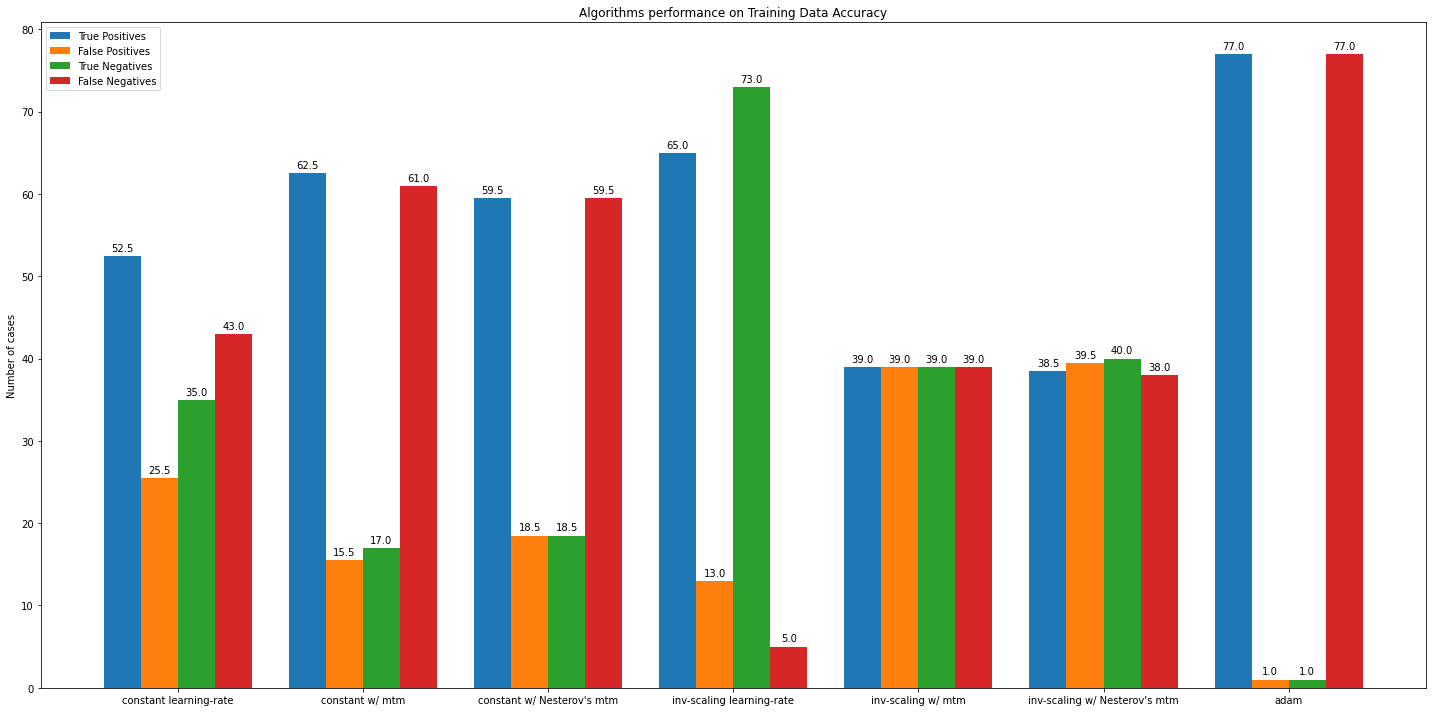

In [166]:
labels = df.iloc[:, 0].to_numpy()
barlabel = ['True Positives','False Positives', 'True Negatives', 'False Negatives']
accuracies = {}
for i in range(4):
    accuracies[barlabel[i]] = [x[int(i/2)][int(i%2)] for x in df.iloc[:, 1]]

x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots(figsize=(20, 10))
rects = [None]*4
for i, j in zip(range(4), accuracies):
    rects[i] = ax.bar(x + (2*i-3)*width/8, accuracies[j], width=width/4, label=barlabel[i])
ax.set_ylabel('Number of cases')
ax.set_title('Algorithms performance on Training Data Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for i in range(4):
    autolabel(rects[i])

fig.tight_layout()

plt.show()